In [1]:
#importing libraries

import pandas as pd
from tensorflow import keras
import cv2

import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

#Sharpening of images
from skimage.io import imshow, imread
from skimage.color import rgb2yuv, rgb2hsv, rgb2gray, yuv2rgb, hsv2rgb
from scipy.signal import convolve2d

In [2]:
#LOAD DATA & APPLY SHARPENING
# ----------------------------------------

from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/IARA/sugarcane_leaf_disease_dataset'  # Path to your 5-class folder


Mounted at /content/drive


In [3]:
target_size = (299,299)
dataset = []
labels = []

for label in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, label)

        if os.path.isdir(class_path):
          images_counter = 0

        #Iterating over all the images in a folder
        for img_name in os.listdir(class_path):
          img_path = os.path.join(class_path, img_name)

          image = cv2.imread(img_path)
          # Check if the image was loaded successfully
          if image is not None:
              # Resize the image
              image = cv2.resize(image, target_size)

              # Add image and label to dataset
              dataset.append(image)
              labels.append(label)


          else:
              print(f"Error loading image: {img_path}")


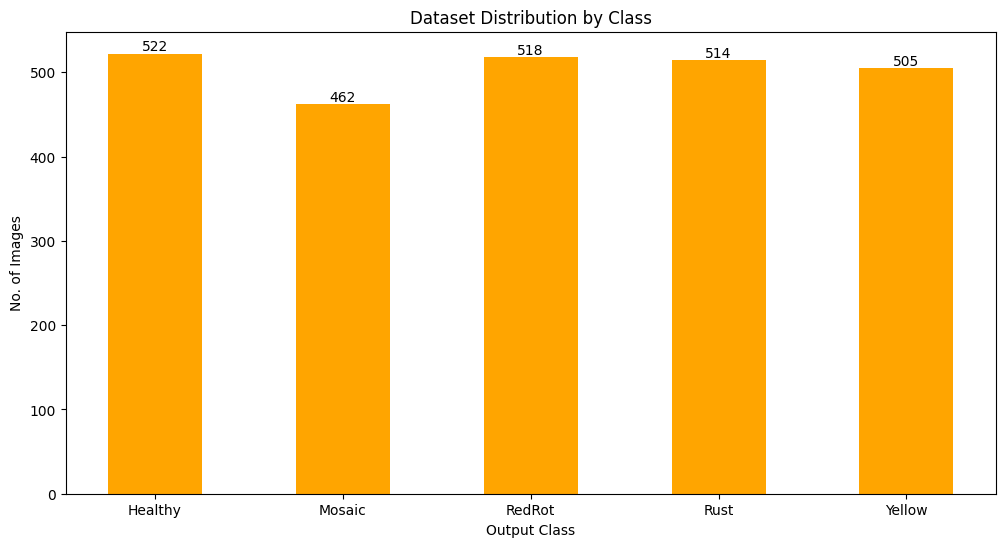

In [4]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_counts.keys(), class_counts.values(), color='orange', width = 0.5)
ax.set_xlabel('Output Class')
ax.set_ylabel('No. of Images')

ax.set_title('Dataset Distribution by Class')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.show()

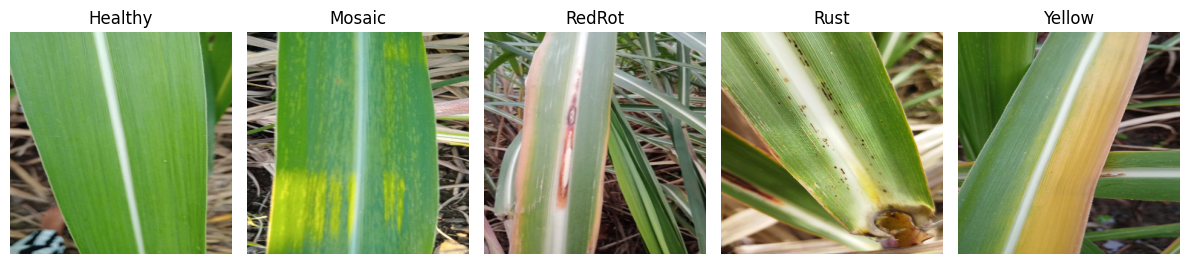

In [5]:
import random

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))

    labels_array = np.array(labels)
    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels_array == class_name)[0]

        if len(indices_class) > 0:
            sample_index = random.choice(indices_class)
        else:
            continue

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(dataset, encoded_labels, test_size = 0.2, random_state = 42 )

def preprocess_image(image):
    resized_image = cv2.resize(image, (299, 299))

    #Normalize values between 0 and 1
    normalized_image = resized_image / 255.0
    return normalized_image

# Apply preprocessing to training and testing sets
X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])

# Check the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (2016, 299, 299, 3)
Shape of X_test: (505, 299, 299, 3)
Shape of y_train: (2016,)
Shape of y_test: (505,)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

num_classes = len(np.unique(y_train))

# Load pre-trained InceptionV3 base
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze for now

# Add custom top layers
inputs = Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,701 (84.17 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stop],
                    )


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.2592 - loss: 1.7451 - val_accuracy: 0.5188 - val_loss: 1.3428
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 691ms/step - accuracy: 0.4060 - loss: 1.4020 - val_accuracy: 0.6059 - val_loss: 1.1790
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 680ms/step - accuracy: 0.4941 - loss: 1.2418 - val_accuracy: 0.6198 - val_loss: 1.0614
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 704ms/step - accuracy: 0.5059 - loss: 1.2214 - val_accuracy: 0.6376 - val_loss: 0.9768
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 687ms/step - accuracy: 0.5880 - loss: 1.0892 - val_accuracy: 0.6554 - val_loss: 0.9415
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 683ms/step - accuracy: 0.5995 - loss: 1.0558 - val_accuracy: 0.6693 - val_loss: 0.8871
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 683ms/step - accuracy: 0.6075 - loss: 1.0037 - val_accuracy: 0.6792 - val_loss: 0.8517
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 697ms/step - accuracy: 0.6461 - loss: 0.9438 - val_accura

Evaluation metrics

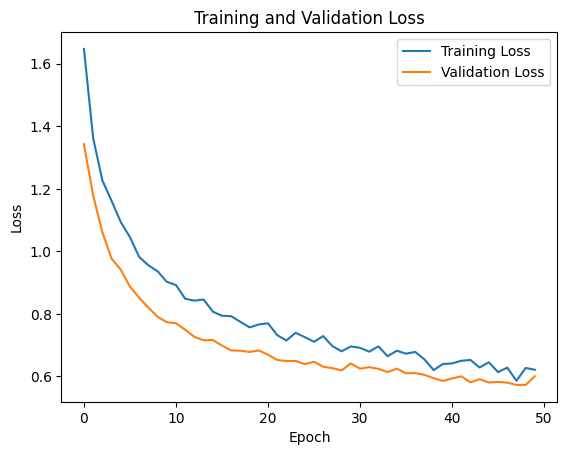

In [11]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

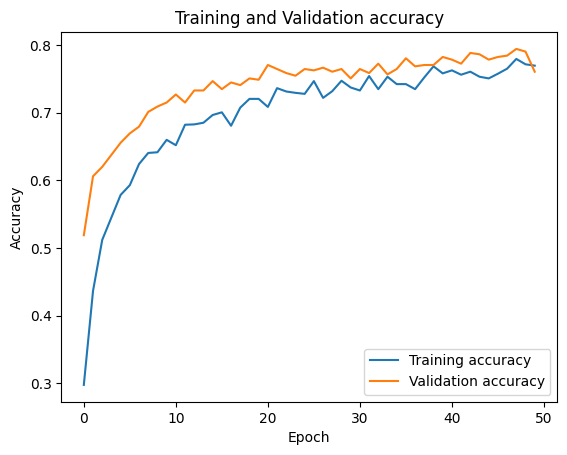

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 534ms/step


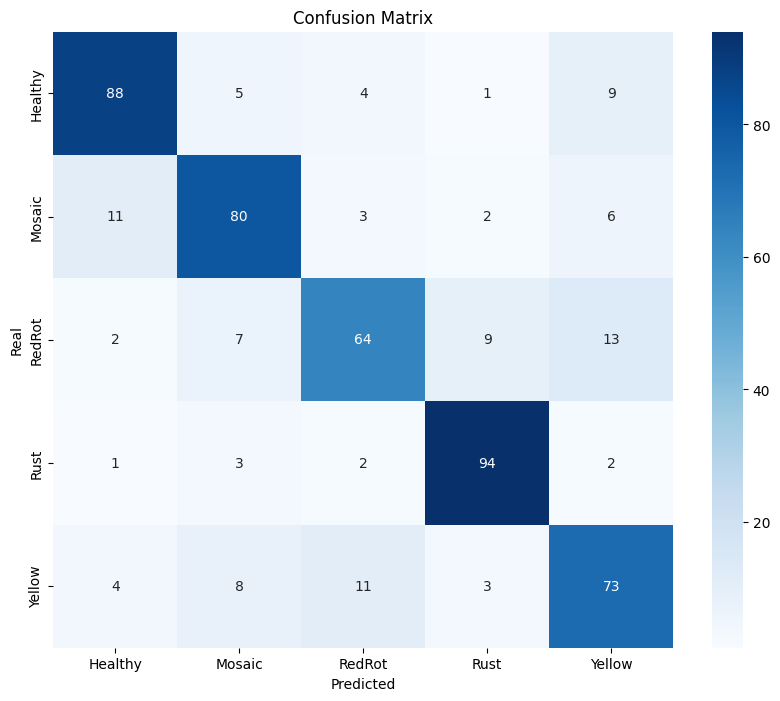

              precision    recall  f1-score   support

     Healthy       0.83      0.82      0.83       107
      Mosaic       0.78      0.78      0.78       102
      RedRot       0.76      0.67      0.72        95
        Rust       0.86      0.92      0.89       102
      Yellow       0.71      0.74      0.72        99

    accuracy                           0.79       505
   macro avg       0.79      0.79      0.79       505
weighted avg       0.79      0.79      0.79       505



In [13]:
#Confusion matrix and classification report for the model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


In [ ]:
# model.save('/content/drive/MyDrive/IARA/inceptionv3_model_sg.h5')


Matthews Correlation Coefficient (MCC): 0.7378
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


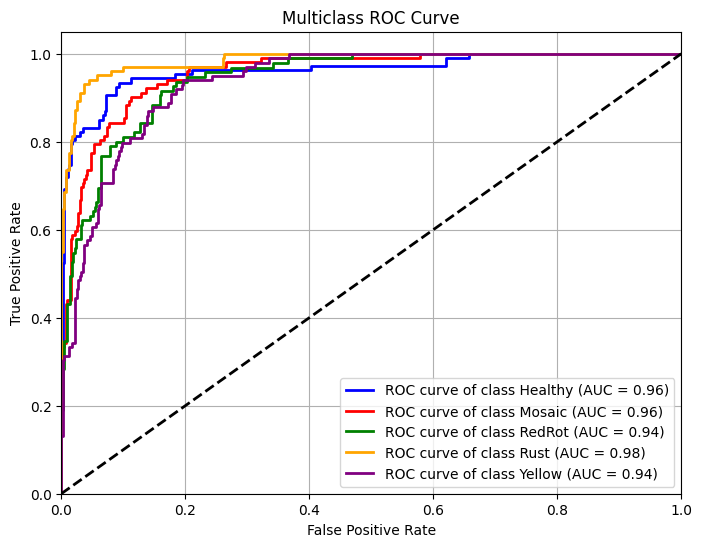

In [14]:
#get roc curve and Mcc
from sklearn.metrics import matthews_corrcoef, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize


mcc = matthews_corrcoef(y_test, y_pred_classes)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# One-hot encode the test labels
y_test_onehot = label_binarize(y_test, classes=range(num_classes))

# Predict probabilities
y_pred_probs = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted class: Mosaic


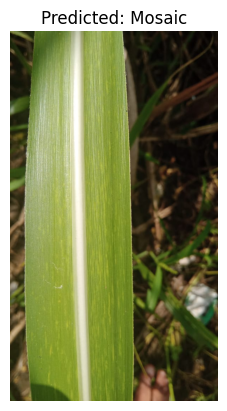

In [15]:
# Provide path to a test image from your dataset
test_image_path = '/content/drive/MyDrive/IARA/sugarcane_leaf_disease_dataset/Mosaic/mosaic (1).jpeg'

# Step 1: Load and preprocess the image
test_img = cv2.imread(test_image_path)
test_img_resized = cv2.resize(test_img, (299, 299))
test_img_normalized = test_img_resized / 255.0
test_img_expanded = np.expand_dims(test_img_normalized, axis=0)  # Shape: (1, 299, 299, 3)

# Step 2: Predict
pred_probs = model.predict(test_img_expanded)
pred_index = np.argmax(pred_probs)
pred_label = label_encoder.inverse_transform([pred_index])[0]

# Step 3: Display prediction
print(f"Predicted class: {pred_label}")

# Optional: Display image with prediction
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {pred_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted class: Yellow


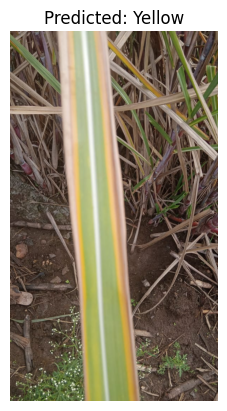

In [17]:
# Provide path to a test image from your dataset
test_image_path = '/content/drive/MyDrive/IARA/sugarcane_leaf_disease_dataset/Yellow/yellow (103).jpeg'

# Step 1: Load and preprocess the image
test_img = cv2.imread(test_image_path)
test_img_resized = cv2.resize(test_img, (299, 299))
test_img_normalized = test_img_resized / 255.0
test_img_expanded = np.expand_dims(test_img_normalized, axis=0)  # Shape: (1, 299, 299, 3)

# Step 2: Predict
pred_probs = model.predict(test_img_expanded)
pred_index = np.argmax(pred_probs)
pred_label = label_encoder.inverse_transform([pred_index])[0]

# Step 3: Display prediction
print(f"Predicted class: {pred_label}")

# Optional: Display image with prediction
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {pred_label}")
plt.axis('off')
plt.show()
